# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: This notebook serves as a general guideline. You are completely free to use your own implementation.**

In [9]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [10]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [11]:
default_seed = 1
output_file = "output_sample"

In [12]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [13]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "output_dataclean_data.pickle", "rb" ) )

In [14]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] =data.loan_status.apply(lambda x: True if x=='Charged Off' or x=='Default' else False)

In [15]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [16]:
# Randomly assign each row to a training and test set. 
#We do this now because we will be fitting a variety of models on various time periods, 
#and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. 
#Hint: use np.random.choice with 70% for training and 30% for testing

data['train'] = np.random.choice([True,False], len(data), p=[0.7, 0.3])

In [17]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [19]:
X

array([[7.3900e+02, 5.0000e+03, 1.3648e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.4400e+02, 2.5000e+03, 1.6870e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [7.3900e+02, 2.4000e+03, 2.9560e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [6.8900e+02, 3.5000e+04, 2.0384e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.3900e+02, 3.1000e+04, 1.0550e+03, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [7.0900e+02, 3.0000e+03, 4.5990e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [20]:
y

array([False,  True, False, ..., False, False, False])

In [21]:
train

array([ True, False,  True, ...,  True,  True, False])

## Prepare functions to fit and evaluate models

In [22]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [33]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize? over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    bestParameters = cv_model.best_params_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
        
    #ouput these two model scores at end of function
    #adjusted for predict probability models by using the best threshold
    accuracyScore = accuracy_score(y_test, y_pred) #return this score for each iteration
    rocAUC = 0 #will be adjusted by following code if model has predict_proba mehtod
    if probs_predicted: 
        rocAUC = roc_auc_score(y_test, y_pred_probs)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'params':bestParameters, 'y_pred_labels':y_pred, 
           'accuracy': accuracyScore, 'rocAUC': rocAUC}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

In [23]:
def hundredSplit_fit_classifier(model,
                                cv_parameters = {}, 
                                model_name = None,
                                random_state = default_seed,
                                data_subset = np.array([True]*len(data)),
                                feature_subset = None,
                                date_range_train = (data.issue_d.min(), data.issue_d.max()),
                                date_range_test = (data.issue_d.min(), data.issue_d.max())):
                                
    topAccScores = [] #stores top score obtained for each train test split
    topAUCScores = [] #stores top score obtained for each train test split
    bestParams = [] #stores top parameters (according to top score) for each train test split
    
    splitCount = 20
    #iterate through 100 random train test splits and store score and parameter results
    for split in range(splitCount):
        #pick new train test split by using new random seed to split data
        np.random.seed(split+1)
        #new random 70 30 train test split
        data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )
        
        #get new train test split with new random state, make sure to carry over dates and data_subset
        data_dictRand = prepare_data(data_subset = data_subset,
                    feature_subset = feature_subset,
                    date_range_train = date_range_train,
                    date_range_test = date_range_test,
                    random_state = default_seed)

        #send train/test split to fit_classification method
        #have method return cv_results best mean score
        modelResults = fit_classification(model, data_dictRand,
                          cv_parameters = cv_parameters,
                          model_name = model_name,
                          random_state = random_state,
                          output_to_file = False,
                          print_to_screen = False)

        #add best score to averages
        topAccScores.append(modelResults['accuracy'])
        topAUCScores.append(modelResults['rocAUC'])
        bestParams.append(tuple(modelResults['params'].values()))

    averageAccuracy = sum(topAccScores)/splitCount
    averageAUC = sum(topAUCScores)/splitCount
    
    #get the parameter settings with the most highest scores
    paramNames = list(modelResults['params'].keys())
    
    #use counter to find the mode. statistics setting will retunr error if multiple
    counter = Counter()
    counter.update(bestParams)
    sortedCounts = sorted(counter.items(), reverse = True, key = lambda x: x[1])
    modeParams = sortedCounts[0][0]
    #modeParams = mode(bestParams)
    bestParamsDict = {paramNames[i]:modeParams[i] for i in range(len(paramNames))}
    
    #print out split results
    if model_name is not None:
        print('Model name:', model_name)
    else:
        print('Model name:', type(model))
    print('best params:', bestParamsDict)
    splitCount = 20
    print('\n*** Model Statistics, ' + str(splitCount) + ' train/test splits ***')
    print('Accuracy: ' + str(round(averageAccuracy,5)) + ' +- ' + str(round(np.std(topAccScores),5)))
    #only print AUC scores if they are available
    if averageAUC != 0:
        print('ROC_AUC: ' + str(round(averageAUC,5)) + ' +- ' + str(round(np.std(topAccScores),5)))

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [24]:
## define your set of features to use in different models
your_features = [col for col in list(data.describe().columns) if data[col].isnull().any()==False]
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: G_Naive_Bayes
Fit time: 0.25 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



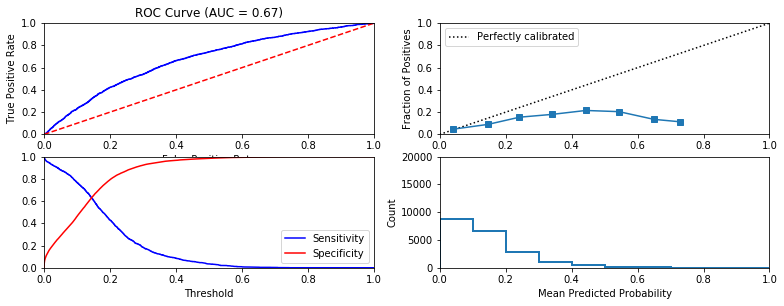


Similarity to LC grade ranking:  0.6247478929466173
Brier score: 0.08586553417254345
Were parameters on edge? : True
Score variations around CV search grid : 0.45098329143871024
[0.90173333 0.8986     0.8978     0.8977     0.8977     0.89766667
 0.89766667 0.89766667]


In [17]:
## Train and test a naive bayes classifier
gnb = GaussianNB()
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb = fit_classification(gnb, data_dict,cv_parameters=cv_parameters,model_name = 'G_Naive_Bayes', random_state=default_seed)

### $l_1$ regularized logistic regression

  Model: l1_logistic model
Fit time: 5.18 seconds
Optimal parameters:
{'C': 0.4, 'tol': 0.0001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



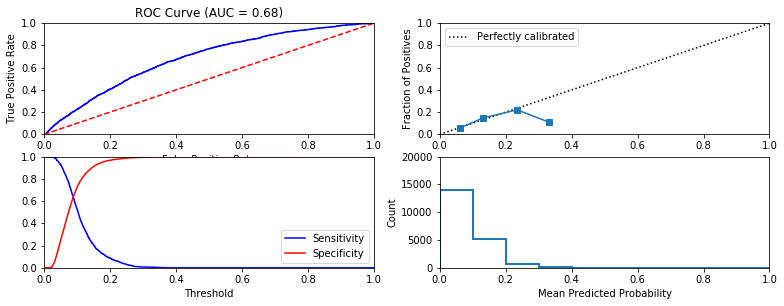


Similarity to LC grade ranking:  0.796247450949899
Brier score: 0.07816359190585719
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [18]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1',solver='liblinear')
cv_parameters = {
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.4, 0.6, 0.8]
}


l1_logistic = fit_classification(l1_logistic, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'l1_logistic model',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

### $l_2$ regularized logistic regression

  Model: l2_logistic model
Fit time: 1.85 seconds
Optimal parameters:
{'C': 0.4, 'tol': 0.0001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



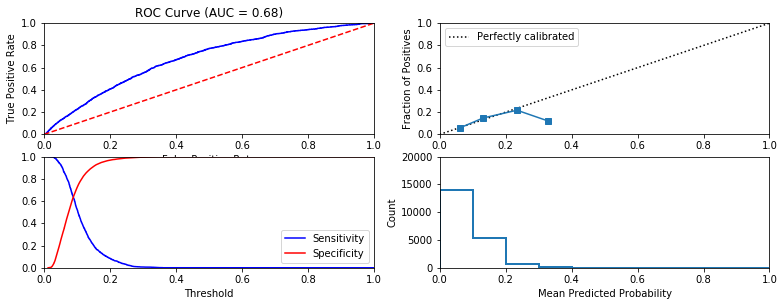


Similarity to LC grade ranking:  0.797823641213403
Brier score: 0.07815872873548152
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [19]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2')
cv_parameters = {
    'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.4, 0.6, 0.8]
}

l2_logistic = fit_classification(l2_logistic, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'l2_logistic model',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

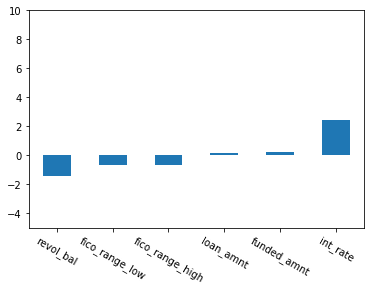

In [20]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: decision_tree model
Fit time: 5.04 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



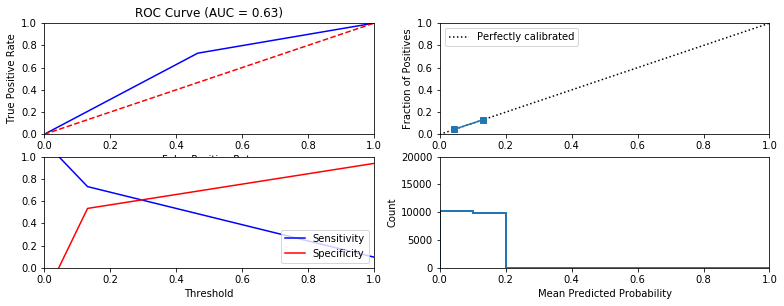


Similarity to LC grade ranking:  0.758175840968437
Brier score: 0.07861611603153827
Were parameters on edge? : True
Score variations around CV search grid : 1.2050832602979853
[0.9128     0.9128     0.9082     0.90843333 0.90986667 0.9087
 0.90833333 0.9071     0.90656667 0.9041     0.9128     0.9128
 0.9128     0.91273333 0.90806667 0.90806667 0.90573333 0.90513333
 0.90483333 0.9018    ]


In [21]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier()
cv_parameters =  {'max_depth':range(1,len(your_features)),'criterion':np.array(['entropy','gini'])}

decision_tree = fit_classification(decision_tree, data_dict,
                          cv_parameters = cv_parameters,
                          model_name = 'decision_tree model')

### Random forest

  Model: Random forest
Fit time: 93.94 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 30}

Accuracy-maximizing threshold was: 0.22600889088253345
Accuracy:  0.88495
              precision    recall  f1-score   support

  No default     0.9166    0.9613    0.9384     18236
     Default     0.1924    0.0952    0.1274      1764

    accuracy                         0.8850     20000
   macro avg     0.5545    0.5283    0.5329     20000
weighted avg     0.8527    0.8850    0.8669     20000



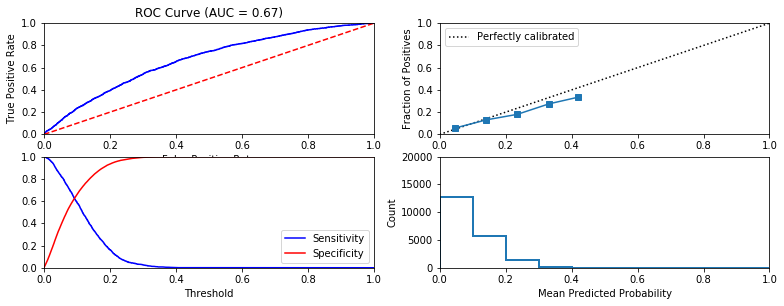


Similarity to LC grade ranking:  0.5584813516722636
Brier score: 0.07848915752962653
Were parameters on edge? : True
Score variations around CV search grid : 0.018258837277252336
[0.91263333 0.91263333 0.91266667 0.9128     0.9128     0.9128
 0.9128     0.9128     0.9128     0.9128     0.9128     0.9128    ]


In [23]:
## Train and test a random forest classifier
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[ 5, 10, 20, 40], 'n_estimators': [30, 60, 120] }

random_forest = fit_classification(random_forest, data_dict,
                                   cv_parameters=cv_parameters, model_name="Random forest")

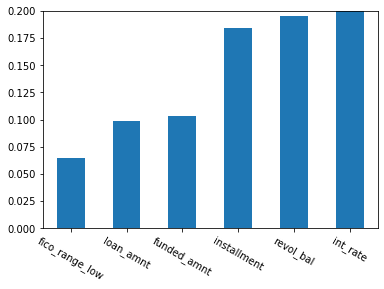

In [24]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-Layer Perceptron
Fit time: 59.98 seconds
Optimal parameters:
{'hidden_layer_sizes': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



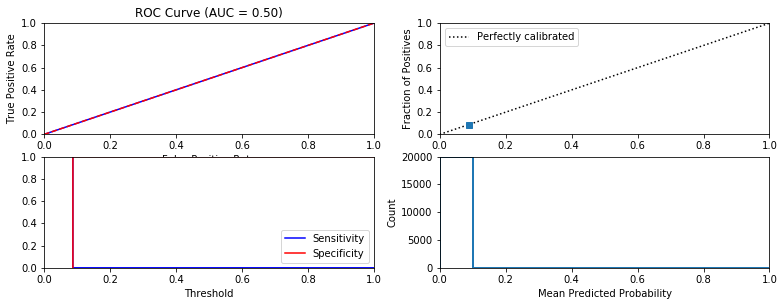


Similarity to LC grade ranking:  -0.007308566044545034
Brier score: 0.0804214114951188
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [25]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

mlp = fit_classification(mlp, data_dict,
                         cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")

## Train and Test logistic regression model with features derived by LendingClub

In [27]:
## train a l2-regularized logistic regression model on data with only that feature
data_dict2=prepare_data(feature_subset=['int_rate'])
l2_onlyLC_logistic = LogisticRegression(penalty='l2',C=np.inf,solver='lbfgs')
l2_onlyLC_logistic = fit_classification(l2_onlyLC_logistic,data_dict=data_dict2, model_name="L2 LogReg_OnlyIntRate")

  Model: L2 LogReg
Fit time: 0.18 seconds
Optimal parameters:
{'alpha': 100.0}

Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000


Similarity to LC grade ranking:  0.8547929839592718


## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [85]:
non_lendingClub_features = set(selected_features).difference({'int_rate', 'grade::B', 'grade::C', 'grade::D',
                                                     'grade::E', 'grade::F', 'grade::G', 'grade::nan'})

data_dict_nonLCFeatures = prepare_data(feature_subset = non_lendingClub_features)

  Model: Naive Bayes
Fit time: 0.23 seconds
Optimal parameters:
{'var_smoothing': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



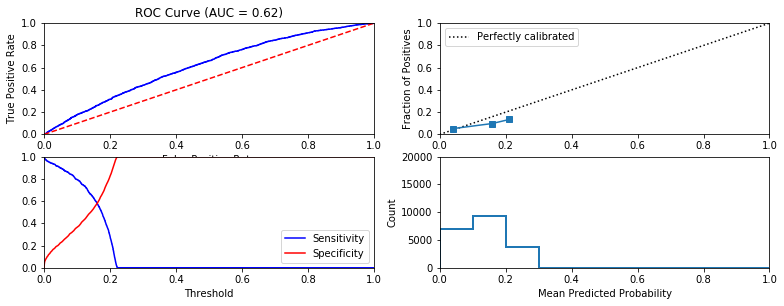


Similarity to LC grade ranking:  0.30485675020403696
Brier score: 0.08253578707658554
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [29]:
#Naive Bayes without Lending Club Features
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb_noLC = GaussianNB()
gnb_noLC = fit_classification(model=gnb_noLC,data_dict=data_dict_nonLCFeatures, cv_parameters=cv_parameters,
                         model_name='Naive Bayes', random_state=default_seed)

In [30]:
#100 train/test split
from collections import Counter
cv_parameters = {'var_smoothing': 10.0 ** -np.arange(2,10)}
gnb_noLC = GaussianNB()
hundredSplit_fit_classifier(model=gnb_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Naive Bayes noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Naive Bayes noLC
best params: {'var_smoothing': 0.01}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.91278 +- 0.00195
ROC_AUC: 0.6118 +- 0.00195


  Model: l1_logistic model
Fit time: 11.74 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



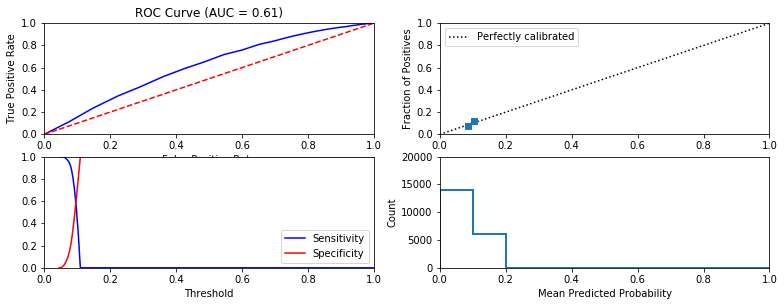


Similarity to LC grade ranking:  0.3386044622858436
Brier score: 0.07979013762534003
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [31]:
## Train and test a l_1 regularized logistic regression classifier
l1_logistic_noLC = LogisticRegression(penalty='l1',solver='liblinear')
cv_parameters = {
    'C': [0.01,0.1,1,5,10,20,50,100]
}


l1_logistic = fit_classification(l1_logistic_noLC, data_dict_nonLCFeatures,
                          cv_parameters = cv_parameters,
                          model_name = 'l1_logistic model',
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True)

In [32]:
#100 train/test split
l1_logistic_noLC = LogisticRegression(penalty='l1',solver='liblinear')
cv_parameters = { 'tol': [1e-4, 1e-3, 1e-2],
    'C': [0.4, 0.6, 0.8]}

hundredSplit_fit_classifier(model=l1_logistic_noLC,
                            cv_parameters=cv_parameters,
                            model_name='L1 LogReg noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)


Model name: L1 LogReg noLC
best params: {'C': 0.4, 'tol': 0.0001}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.91278 +- 0.00197
ROC_AUC: 0.61298 +- 0.00197


# L2 regularized Logistic regression without Lending Club Data

  Model: L2 LogReg
Fit time: 1.53 seconds
Optimal parameters:
{'C': 0.01}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



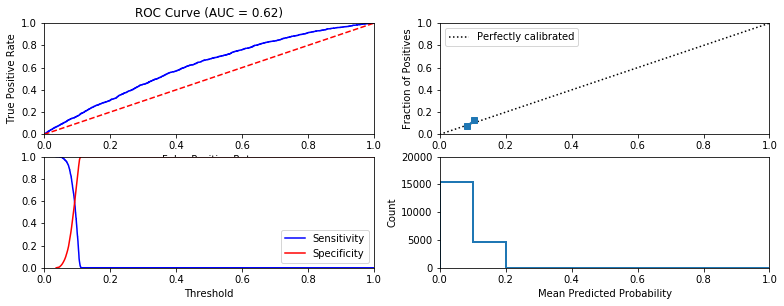


Similarity to LC grade ranking:  0.3403139016907278
Brier score: 0.07969460170084376
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [33]:
## Train and test a l_2 regularized logistic regression classifier
l2_logistic_noLC = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.01,0.1,1,5,10,20,50,100]}

l2_logistic_noLC = fit_classification(l2_logistic_noLC,data_dict_nonLCFeatures,
                    cv_parameters=cv_parameters,model_name="L2 LogReg", 
                    random_state=default_seed,output_to_file=True,print_to_screen=True)

In [34]:
l2_logistic_noLC = LogisticRegression(penalty='l2')
cv_parameters = {'C': [0.0001,0.001,0.01,0.1,1,5,10,100]}
hundredSplit_fit_classifier(model=l2_logistic_noLC,
                            cv_parameters=cv_parameters,
                            model_name='L2 LogReg noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: L2 LogReg noLC
best params: {'C': 0.0001}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.91279 +- 0.00196
ROC_AUC: 0.60542 +- 0.00196


# Decision Tree Without Lending Club Data

  Model: Decision Tree
Fit time: 4.42 seconds
Optimal parameters:
{'criterion': 'entropy', 'max_depth': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



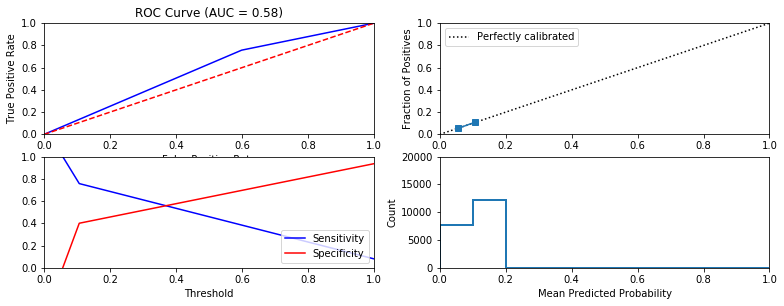


Similarity to LC grade ranking:  0.3552123133965732
Brier score: 0.0797427680843095
Were parameters on edge? : True
Score variations around CV search grid : 0.6536663745252712
[0.9128     0.9128     0.9128     0.9128     0.9127     0.9119
 0.911      0.91016667 0.90826667 0.90683333 0.9128     0.9128
 0.91266667 0.91263333 0.9122     0.912      0.91136667 0.91016667
 0.90903333 0.90713333]


In [35]:
## Train and test a decision tree classifier
decision_tree_noLC = DecisionTreeClassifier()

cv_parameters =  {'max_depth':range(1,len(your_features)),'criterion':np.array(['entropy','gini'])}
decision_tree_noLC = fit_classification(decision_tree_noLC,data_dict=data_dict_nonLCFeatures,
                    cv_parameters=cv_parameters,model_name="Decision Tree")


In [36]:
decision_tree_noLC = DecisionTreeClassifier()
cv_parameters =  {'max_depth':range(1,len(your_features)),'criterion':np.array(['entropy','gini'])}
hundredSplit_fit_classifier(model=decision_tree_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Decision Tree noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Decision Tree noLC
best params: {'criterion': 'entropy', 'max_depth': 1}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.91279 +- 0.00196
ROC_AUC: 0.5757 +- 0.00196


# Random Forest Without Lending Club Data

  Model: Random Forest NO LC
Fit time: 281.31 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 30}

Accuracy-maximizing threshold was: 0.34170084452894484
Accuracy:  0.7908
              precision    recall  f1-score   support

  No default     0.8141    0.9584    0.8804     16062
     Default     0.3872    0.1072    0.1679      3938

    accuracy                         0.7908     20000
   macro avg     0.6006    0.5328    0.5241     20000
weighted avg     0.7300    0.7908    0.7401     20000



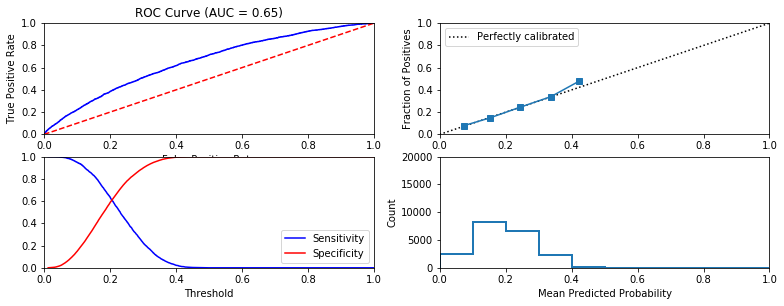


Similarity to LC grade ranking:  0.4082978926021045
Brier score: 0.15065652697621607
Were parameters on edge? : True
Score variations around CV search grid : 0.07044880029836363
[0.8038     0.80403333 0.80433333 0.8042     0.8043     0.80433333
 0.80436667 0.80436667 0.80436667]


In [86]:
random_forest_noLC = RandomForestClassifier()

cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }

random_forest_noLC = fit_classification(random_forest_noLC,data_dict_nonLCFeatures,
                    cv_parameters=cv_parameters,model_name="Random Forest NO LC", 
                    random_state=default_seed)

In [42]:
random_forest_noLC = RandomForestClassifier()

cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }
hundredSplit_fit_classifier(model=random_forest_noLC,
                            cv_parameters=cv_parameters,
                            model_name='Random Forest noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: Random Forest noLC
best params: {'min_samples_leaf': 10, 'n_estimators': 30}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.889 +- 0.00522
ROC_AUC: 0.60674 +- 0.00522


# MultiLayer Perceptron Without Lending Club Data

  Model: Multi-Layer Perceptron
Fit time: 38.7 seconds
Optimal parameters:
{'hidden_layer_sizes': 1}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9118
              precision    recall  f1-score   support

  No default     0.9118    1.0000    0.9539     18236
     Default     0.0000    0.0000    0.0000      1764

    accuracy                         0.9118     20000
   macro avg     0.4559    0.5000    0.4769     20000
weighted avg     0.8314    0.9118    0.8697     20000



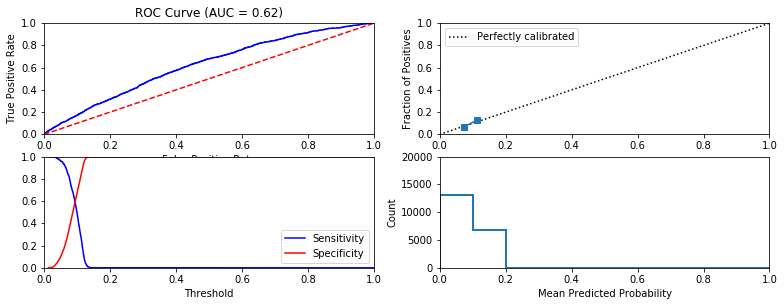


Similarity to LC grade ranking:  0.3454697975429243
Brier score: 0.07937006656660173
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.9128 0.9128 0.9128 0.9128 0.9128 0.9128]


In [43]:
mlp_noLC = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

mlp_noLC = fit_classification(mlp_noLC, data_dict_nonLCFeatures,
                         cv_parameters = cv_parameters, model_name="Multi-Layer Perceptron")

In [44]:
#100 train/test split
mlp_noLC = MLPClassifier()
cv_parameters = {'hidden_layer_sizes':[(1), (10), (50), (100), (5, 5), (10, 10)]}

hundredSplit_fit_classifier(model=mlp_noLC,
                            cv_parameters=cv_parameters,
                            model_name='MLP noLC', 
                            random_state=default_seed,
                            feature_subset = non_lendingClub_features)

Model name: MLP noLC
best params: {'hidden_layer_sizes': 1}

*** Model Statistics, 20 train/test splits ***
Accuracy: 0.91279 +- 0.00196
ROC_AUC: 0.5449 +- 0.00196


## Time stability test of YOURMODEL

  Model: Time stability test:2010 to 2018
Fit time: 55.74 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 30}

Accuracy-maximizing threshold was: 0.23367917559584883
Accuracy:  0.751
              precision    recall  f1-score   support

  No default     0.7984    0.9111    0.8510      5465
     Default     0.3639    0.1811    0.2418      1535

    accuracy                         0.7510      7000
   macro avg     0.5812    0.5461    0.5464      7000
weighted avg     0.7031    0.7510    0.7175      7000



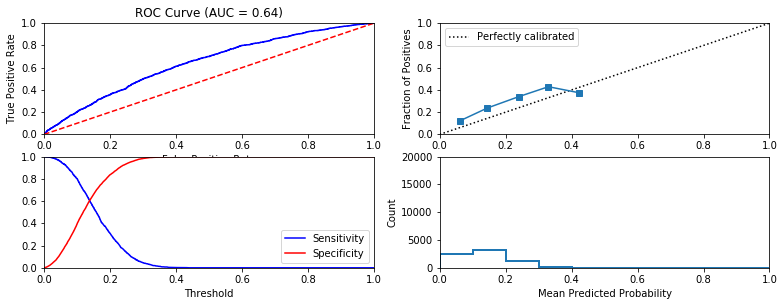


Similarity to LC grade ranking:  0.4798822390756303
Brier score: 0.17102109199476578
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.88425 0.88425 0.88425 0.88425 0.88425 0.88425 0.88425 0.88425 0.88425]


{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=10, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=30,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'params': {'min_samples_leaf': 10, 'n_estimators': 30},
 'y_pred_labels': array([False, False, False, ..., False,  True, False]),
 'accuracy': 0.751,
 'rocAUC': 0.6421631287047275,
 'y_pred_probs': array([0.13796715, 0.10226265, 0.0614357 , ..., 0.07468832, 0.2480474 ,
        0.07708898])}

In [34]:
## Define the time window of your train and test data
YOURMODEL = RandomForestClassifier()
#train model using 2010 data
start_date_train = datetime.date(year=2010, month=1,day=1)
end_date_train = datetime.date(year=2010, month=12,day=31)

#predictions for 2018
start_date_test = datetime.date(year=2018, month=1,day=1)
end_date_test = datetime.date(year=2018, month=12,day=31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 8000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }

fit_classification(YOURMODEL,data_dict_test,cv_parameters=cv_parameters,
                   model_name="Time stability test:2010 to 2018",output_to_file=True,print_to_screen=True)

  Model: Time stability test RF: 2017 trained 2018 tested
Fit time: 52.52 seconds
Optimal parameters:
{'min_samples_leaf': 20, 'n_estimators': 120}

Accuracy-maximizing threshold was: 0.35967279449437345
Accuracy:  0.7648571428571429
              precision    recall  f1-score   support

  No default     0.8025    0.9261    0.8599      5454
     Default     0.4292    0.1960    0.2691      1546

    accuracy                         0.7649      7000
   macro avg     0.6158    0.5610    0.5645      7000
weighted avg     0.7201    0.7649    0.7294      7000



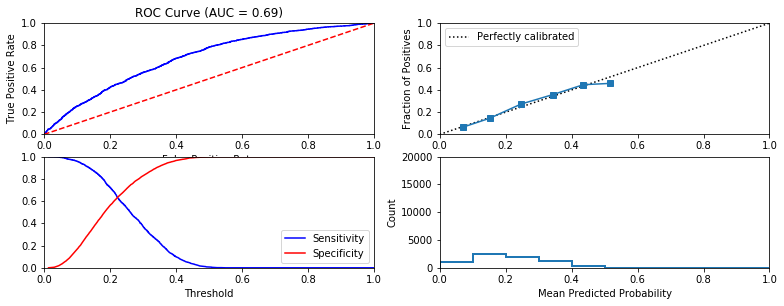


Similarity to LC grade ranking:  0.627091722867514
Brier score: 0.1596377514169804
Were parameters on edge? : True
Score variations around CV search grid : 0.19774011299433322
[0.78511111 0.78622222 0.78588889 0.78655556 0.78566667 0.78666667
 0.78611111 0.78633333 0.78633333]


{'model': RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=20, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=120,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 'params': {'min_samples_leaf': 20, 'n_estimators': 120},
 'y_pred_labels': array([False, False, False, ..., False,  True,  True]),
 'accuracy': 0.7648571428571429,
 'rocAUC': 0.6879587053142571,
 'y_pred_probs': array([0.08280359, 0.18386411, 0.07117517, ..., 0.29395203, 0.46945374,
        0.39843893])}

In [35]:
#training model using 2017 data
start_date_train = datetime.date(year = 2017, month = 1, day = 1)
end_date_train = datetime.date(year = 2017, month = 12, day = 31)

start_date_train = datetime.date(year = 2018, month = 1, day = 1)
end_date_train = datetime.date(year = 2018, month = 12, day = 31)

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }
## Train and test YOURMODEL using this data
fit_classification(model=YOURMODEL,data_dict=data_dict_test,model_name="Time stability test RF: 2017 trained 2018 tested", 
                    cv_parameters =cv_parameters, random_state=default_seed,output_to_file=True,print_to_screen=True)

## Train and test YOURMODEL on the original data

In [94]:
import glob

def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False
    
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        ...
    
    all_files = glob.glob(directory+"/*.zip") # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(i, dtype='str',skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        df = output[i]
        invalid_rows = df.id.apply(lambda x: is_integer(x))==False # mask rows that have non-integer IDs. Use is_integer method
        #invalid_rows = invalid_rows[invalid_rows==False]
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = df.drop(invalid_rows[invalid_rows==True].index) # remove invalid rows
    
    return output # return dictionary of dataframe

files_cs = ingest_files("./2003_download")

Directory ./2003_download has 20 files:
    Reading file ./2003_download\LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file ./2003_download\LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file ./2003_download\LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file 

In [97]:
# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id','loan_amnt', 'funded_amnt', 'funded_amnt_inv','term', 'int_rate', 'installment', 'grade', 'sub_grade','emp_title','emp_length',
'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status',
'purpose', 'title','zip_code','addr_state','dti', 'total_pymnt','delinq_2yrs', 'earliest_cr_line', 'open_acc', 'pub_rec',
'fico_range_high', 'fico_range_low', 'last_fico_range_high','last_fico_range_low','revol_bal', 'revol_util',
'application_type','last_pymnt_amnt','last_pymnt_d', 'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt','funded_amnt','funded_amnt_inv','installment','annual_inc','dti','delinq_2yrs','open_acc','pub_rec','fico_range_high', 'fico_range_low',
             'revol_bal','total_pymnt','recoveries','last_pymnt_amnt','last_fico_range_high','last_fico_range_low']
cat_cols = ['term','grade','sub_grade','emp_length','home_ownership','verification_status','loan_status','purpose','application_type','title','emp_title','zip_code','addr_state'] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [98]:
raw_data = pd.DataFrame(data_cs, columns=cols_to_pick)
#raw_data = raw_data.iloc[:1000000,:]
for i in float_cols:
    raw_data[i] = raw_data[i].astype('float')
def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

for i in perc_cols:
    raw_data[i] = raw_data[i].apply(lambda x: clean_perc(x)) # apply clean_perc to percentage columns
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    raw_data[i] = raw_data[i].apply(lambda x: clean_date(x)) # typecast date cloumns to datatime using clean_date
for i in cat_cols:
    raw_data[i] = raw_data[i].fillna("None")

In [114]:
discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

In [115]:
raw_data["outcome"] = 0
raw_data["outcome"] = data.eval("loan_status == 'Charged Off' or loan_status == 'Default'")
p=[0.3,0.7]
raw_data['train'] = np.random.choice([True,False],len(raw_data),p=p)
raw_data.train.value_counts()

False    1938489
True      830692
Name: train, dtype: int64

In [101]:
raw_data = raw_data.dropna()

In [102]:
#for col in discrete_features:
df = raw_data[discrete_features]
for col in df.columns:
    df_sub = df.groupby(col)[[col]].count()
    df_sub = df_sub.rename(columns={col: "count"})
    df_sub = df_sub.sort_values(by='count', ascending=False)
    print(df_sub.index[0:3])
    df[col] = df[col].where(df[col].isin(list(df_sub.index[3:]))==False, 'Other')

Index(['MORTGAGE', 'RENT', 'OWN'], dtype='object', name='home_ownership')
Index(['Debt consolidation', 'Credit card refinancing', 'Home improvement'], dtype='object', name='title')
Index(['Source Verified', 'Not Verified', 'Verified'], dtype='object', name='verification_status')
Index(['None', 'Teacher', 'Manager'], dtype='object', name='emp_title')
Index(['10+ years', '< 1 year', '2 years'], dtype='object', name='emp_length')
Index(['Individual', 'Joint App'], dtype='object', name='application_type')
Index(['CA', 'TX', 'NY'], dtype='object', name='addr_state')
Index(['B4', 'C1', 'B5'], dtype='object', name='sub_grade')
Index(['112xx', '750xx', '945xx'], dtype='object', name='zip_code')
Index([' 36 months', ' 60 months'], dtype='object', name='term')
Index(['debt_consolidation', 'credit_card', 'home_improvement'], dtype='object', name='purpose')
Index(['B', 'C', 'A'], dtype='object', name='grade')


In [110]:
X_continuous = raw_data[continuous_features].values

X_discrete = pd.get_dummies(df, dummy_na = True, prefix_sep = "::", drop_first = True)
X_discrete.head()
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = raw_data.outcome.values

train = raw_data.train.values

In [116]:
## define your set of features to use in different models
your_features = discrete_features + ret_cols + continuous_features  

# prepare the train, test data for training models
data_dict_all = prepare_data(data_subset = np.array([True]*len(data)), feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Random Forest
Fit time: 81.91 seconds
Optimal parameters:
{'min_samples_leaf': 10, 'n_estimators': 120}

Accuracy-maximizing threshold was: 0.4670400680401841
Accuracy:  0.97535
              precision    recall  f1-score   support

  No default     0.9817    0.9916    0.9866     18315
     Default     0.8973    0.7988    0.8452      1685

    accuracy                         0.9754     20000
   macro avg     0.9395    0.8952    0.9159     20000
weighted avg     0.9746    0.9754    0.9747     20000



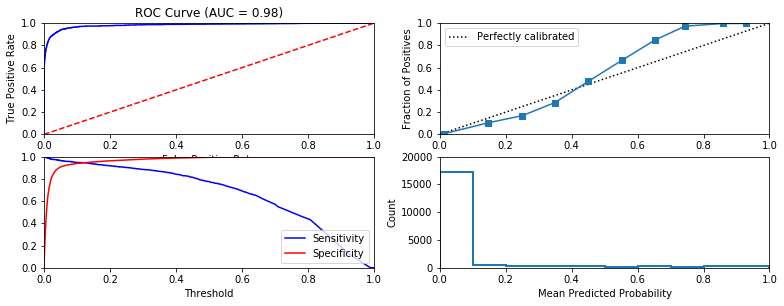


Similarity to LC grade ranking:  0.3154056429080798
Brier score: 0.02049717699408343
Were parameters on edge? : True
Score variations around CV search grid : 0.6760698719928445
[0.97066667 0.97003333 0.9713     0.96656667 0.9676     0.9693
 0.9654     0.96473333 0.96633333]


In [117]:
random_forest = RandomForestClassifier()
cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }

random_forest  = fit_classification(random_forest,data_dict_all, model_name='Random Forest',cv_parameters = cv_parameters)

## Test regression models

In [26]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].as_matrix()
        y_test = data.loc[filter_test, ret_col].as_matrix() 

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [28]:
## First, trying l1 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.001,0.01,0.1,0.2] }

reg_lasso = fit_regression(linear_model.LassoLars(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Lasso")

  Model: Lasso  Return column: ret_PESS
Fit time: 0.32 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: -5.411019292655972e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.17206309 -0.17206309 -0.17206309 -0.17206309]
  Model: Lasso  Return column: ret_OPT
Fit time: 0.27 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: -6.958165277293205e-07
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.03130323 -0.03130323 -0.03130323 -0.03130323]
  Model: Lasso  Return column: ret_INTa
Fit time: 0.28 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: -3.6718854601547335e-05
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.14843767 -0.14843767 -0.14843767 -0.14843767]
  Model: Lasso  Return column: ret_INTb
Fit time: 0.27 seconds
Optimal parameters:
{'alpha'

### $l_2$ regularized linear regressor

In [29]:
## trying l2 regularized linear regression with hyper-parameters

cv_parameters = {'alpha': [0.001,0.01,0.1,0.2]}

reg_ridge = fit_regression(linear_model.Ridge(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Ridge")

  Model: Ridge  Return column: ret_PESS
Fit time: 0.42 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.02360578180319639
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.023440192258369984
All test scores : [-0.14868352 -0.14868663 -0.14870182 -0.14871837]
  Model: Ridge  Return column: ret_OPT
Fit time: 0.38 seconds
Optimal parameters:
{'alpha': 0.2}

Testing r2 score: 0.006344276254276027
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.29041833133591205
All test scores : [-0.02228065 -0.02227835 -0.02224539 -0.02221613]
  Model: Ridge  Return column: ret_INTa
Fit time: 0.37 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.03000901484275942
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.03814435374996451
All test scores : [-0.12437125 -0.12437584 -0.1243973  -0.12441869]
  Model: Ridge  Return column: ret_INTb
Fit time: 0.4

### Multi-layer perceptron regressor

In [30]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = { 'alpha':[0.001, 0.01, 0.1, 1, 10, 100],
                  'hidden_layer_sizes':[(1), (10), (50), (100), (200), (5, 5), (10, 10)] }

reg_mlp = fit_regression(MLPRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Multi-Layer Perceptron")

  Model: Multi-Layer Perceptron  Return column: ret_PESS
Fit time: 570.95 seconds
Optimal parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 200}

Testing r2 score: 0.032605587186128715
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -81.86253254884654
All test scores : [-0.15486769 -0.182487   -0.13980877 -0.12463544 -0.16129535 -0.18488398
 -0.15693017 -0.17622771 -0.16240256 -0.15545435 -0.1247331  -0.11590935
 -0.16021404 -0.18454342 -0.20836111 -0.15194657 -0.19234813 -0.16265443
 -0.21079568 -0.1978359  -0.14190005 -0.17405601 -0.18542354 -0.12868114
 -0.17748514 -0.14795588 -0.16400757 -0.17521395 -0.16253768 -0.16141047
 -0.17839613 -0.19328455 -0.13453014 -0.16247234 -0.15573495 -0.17324752
 -0.16936108 -0.15682174 -0.16368477 -0.15538244 -0.17474198 -0.15672153]
  Model: Multi-Layer Perceptron  Return column: ret_OPT
Fit time: 589.59 seconds
Optimal parameters:
{'alpha': 0.01, 'hidden_layer_sizes': 50}

Testing r2 score: 0.0010286654964

### Random forest regressor

In [36]:
## trying random forest regression with hyper-parameters

cv_parameters = {'min_samples_leaf':[10, 20, 40], 'n_estimators': [30, 60, 120] }

reg_rf = fit_regression(RandomForestRegressor(), data_dict,
               cv_parameters = cv_parameters, separate = False, model_name = "Random forest regressor")

  Model: Random forest regressor  Return column: ret_PESS
Fit time: 1309.62 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 120}

Testing r2 score: 0.04681164874865229
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -14.808669227067917
All test scores : [-0.15662199 -0.14908183 -0.14446132 -0.14346987 -0.1391168  -0.14008312
 -0.14163701 -0.13873781 -0.13642   ]
  Model: Random forest regressor  Return column: ret_OPT
Fit time: 1120.74 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 120}

Testing r2 score: 0.017749435967282734
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -163.11643507740976
All test scores : [-0.0389446  -0.02877268 -0.02627937 -0.02679227 -0.02225605 -0.01928306
 -0.01761584 -0.01584004 -0.01480128]
  Model: Random forest regressor  Return column: ret_INTa
Fit time: 1125.1 seconds
Optimal parameters:
{'min_samples_leaf': 40, 'n_estimators': 120}

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [55]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test[0:num_loans]

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test[0:num_loans]

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

In [56]:
##loop through test investments. 100 train/test
def hundredSplit_test_investments(classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    splitCount = 100
    retPESS = [] #lists to hold the investment return values from each split
    retOPT = []
    retINTa = []
    retINTb = []
    for split in range(splitCount):
        #pick new train test split by using new random seed to split data
        np.random.seed(split+1)
        #new random 70 30 train test split
        data['train'] = np.random.choice([True,False], len(data),p=[0.7,0.3] )
        
        #get new train test split using the new train column created above
        data_dictRand = prepare_data(feature_subset = your_features)
        
        #pass argument to test_invetment method
        strat_returns = test_investments(data_dictRand, classifier = classifier, regressor = regressor, strategy = strategy, 
                              num_loans = num_loans, random_state = random_state, output_to_file = False)
        #save return investment outcomes to lists
        retPESS.append(strat_returns['ret_PESS']['average return'])
        retOPT.append(strat_returns['ret_OPT']['average return'])
        retINTa.append(strat_returns['ret_INTa']['average return'])
        retINTb.append(strat_returns['ret_INTb']['average return'])
    
    #print out average and standard devations of all 100 returns
    print('*** Investment test outcomes - ' + str(splitCount) + ' splits ***')
    print('strategy:',test_strategy)   
    print('ret_PESS: ', round(sum(retPESS)/splitCount,7), '+-', round(np.std(retPESS),7))
    print('ret_OPT: ', round(sum(retOPT)/splitCount,7), '+-', round(np.std(retOPT),7))
    print('ret_INTa: ', round(sum(retINTa)/splitCount,7), '+-', round(np.std(retINTa),7))
    print('ret_INTb: ', round(sum(retINTb)/splitCount,7), '+-', round(np.std(retINTb),7))

In [57]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'

print('strategy:',test_strategy)   
strat_rand = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_rf, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))

strategy: Random
ret_PESS: -0.005831376619220635
ret_OPT: 0.043013272847434406
ret_INTa: 0.014936008642907667
ret_INTb: 0.05056207985240783


In [41]:
# 100 investment splits
test_strategy = 'Random'

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_rf, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Random
ret_PESS:  -0.0052838 +- 0.0028045
ret_OPT:  0.0408786 +- 0.0038075
ret_INTa:  0.0146714 +- 0.0021824
ret_INTb:  0.0490635 +- 0.0024632


In [87]:
test_strategy = 'Default-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, classifier = random_forest_noLC, regressor = reg_rf, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Default-based
ret_PESS: -0.0097587830577347
ret_OPT: 0.03791746978768417
ret_INTa: 0.018992382130032858
ret_INTb: 0.055775163705620065


In [90]:
# 100 investment splits
test_strategy = 'Default-based'

hundredSplit_test_investments(classifier = random_forest_noLC, regressor = reg_rf, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Default-based
ret_PESS:  -0.0069333 +- 0.0034479
ret_OPT:  0.039808 +- 0.0033715
ret_INTa:  0.0147468 +- 0.0022461
ret_INTb:  0.0507041 +- 0.0024388


In [71]:
test_strategy = 'Return-based'

print('strategy:',test_strategy)
strat_ret = test_investments(data_dict, classifier = YOURMODEL, regressor = reg_rf, strategy = test_strategy, 
                              num_loans = 1000, random_state = default_seed,output_to_file = True)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

strategy: Return-based
ret_PESS: 0.024017872121333005
ret_OPT: 0.04036619310326736
ret_INTa: 0.016290682533564346
ret_INTb: 0.04811289879777859


In [72]:
# 100 investment splits
test_strategy = 'Return-based'

hundredSplit_test_investments(classifier = YOURMODEL, regressor = reg_rf, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Return-based
ret_PESS:  0.0171949 +- 0.0027865
ret_OPT:  0.040697 +- 0.0033053
ret_INTa:  0.0163035 +- 0.0022648
ret_INTb:  0.0488514 +- 0.0025231


In [74]:
test_strategy = 'Default-return-based'

## For the Default-return-based strategy we need to fit a new regressor with separate = True
cv_parameters = {'min_samples_leaf':[10, 20, 40]}

reg_rf_separate = fit_regression(RandomForestRegressor(), data_dict,
                       cv_parameters = cv_parameters, separate = True, model_name = "Random forest regressor",
                                     print_to_screen = False, output_to_file = False)


In [91]:
print('strategy:',test_strategy)
strat_defret = test_investments(data_dict, classifier = random_forest_noLC, regressor = reg_rf_separate, 
                             strategy = test_strategy, num_loans = 1000)

for ret_col in col_list:
    print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

strategy: Default-based
ret_PESS: -0.0097587830577347
ret_OPT: 0.03791746978768417
ret_INTa: 0.018992382130032858
ret_INTb: 0.055775163705620065


### 100 test investment splits

In [92]:
test_strategy = 'Default-return-based'

hundredSplit_test_investments(classifier = random_forest_noLC, regressor = reg_rf_separate, 
                             strategy = test_strategy, num_loans = 1000, 
                             random_state = default_seed, output_to_file = True)

*** Investment test outcomes - 100 splits ***
strategy: Default-return-based
ret_PESS:  0.0110944 +- 0.00268
ret_OPT:  0.0402969 +- 0.0037374
ret_INTa:  0.0153962 +- 0.0018358
ret_INTb:  0.0509785 +- 0.0025516


## Sensitivity test of portfolio size

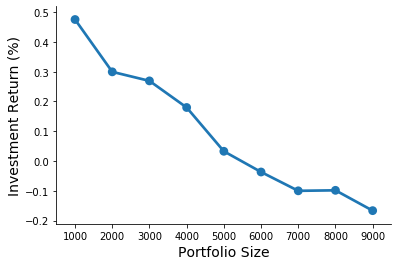

In [93]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, classifier = random_forest_noLC, regressor = reg_rf_separate, strategy = 'Default-return-based', 
                              num_loans = num_loans, random_state = default_seed,output_to_file = True)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(np.array(list(range(1000,10000,1000))),result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()